https://www.kaggle.com/ruchibahl18/cats-vs-dogs-basic-cnn-tutorial

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### Data Preprocessing

Just wanna know how the first data looks like.

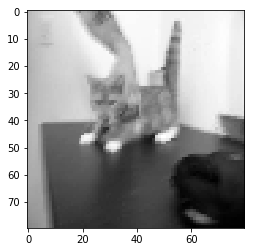

In [2]:
train_dir = "train"
path = train_dir

for p in os.listdir(path):
    category = p.split(".")[0]
    #print(category)
    img_array = cv2.imread(os.path.join(train_dir, p), cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80,80))
    plt.imshow(new_img_array, cmap='gray')
    break

In [6]:
X = []
y = []

# Klo dog jadi 1, klo selain dog (cat) jadi 0 (aslinya ini tu
# true false, tapi kalo di integer in jadi 1/0)
convert = lambda category : int(category == 'dog')

def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)   # Dapet 0 atau 1
        img_array = cv2.imread(os.path.join(path,p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80,80))    # Dapet gambarnya
        X.append(new_img_array)
        y.append(category)

In [8]:
create_test_data(path)

The author itself doesn't really understand why we need to reshape the data that way.

In [31]:
X = np.array(X).reshape(-1, 80, 80, 1)
X = X/255.0    # Normalize the data

y = np.array(y)

Saving the data into pickle file to make it load faster in future use.

In [32]:
import pickle

with open("train_X", 'wb') as handle:
    pickle.dump(X, handle, protocol=2)
    
with open("train_y", 'wb') as handle:
    pickle.dump(y, handle, protocol=2)

# Cara nge load nya gini
''' 
with open(config.p_path, 'rb') as handle:	# 'rb' means read bytes (because pickles are in bytes)
    tmp = pickle.load(handle)
    return tmp
'''

" \nwith open(config.p_path, 'rb') as handle:\t# 'rb' means read bytes (because pickles are in bytes)\n    tmp = pickle.load(handle)\n    return tmp\n"

### Creating Model

In [34]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', 
          input_shape=X.shape[1:]))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 78, 78, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1327168   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [35]:
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.5718 - accuracy: 0.7049 - val_loss: 0.7261 - val_accuracy: 0.5862
Epoch 2/10
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.4750 - accuracy: 0.7770 - val_loss: 0.7744 - val_accuracy: 0.5726
Epoch 3/10
20000/20000 [==============================] - 34s 2ms/sample - loss: 0.4185 - accuracy: 0.8066 - val_loss: 0.6871 - val_accuracy: 0.6716
Epoch 4/10
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.3667 - accuracy: 0.8359 - val_loss: 0.4881 - val_accuracy: 0.7864
Epoch 5/10
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.3065 - accuracy: 0.8671 - val_loss: 0.6358 - val_accuracy: 0.7154
Epoch 6/10
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.2337 - accuracy: 0.9020 - val_loss: 0.5781 - val_accuracy: 0.7800
Epoch 7/10
20000/20000 [==============================] -

### Preprocess Testing Data
Keep in mind that test data does not have label.

In [46]:
test_dir = "test"
path = test_dir

X_test = []
id_line = []

def create_test_data(path):
    for p in os.listdir(path):
        id_line.append(p.split(".")[0])   # Take the file number (not the label)
        img_array = cv2.imread(os.path.join(path,p), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80,80))
        X_test.append(new_img_array)

create_test_data(path)
X_test = np.array(X_test).reshape(-1, 80, 80, 1)
X_test = X_test/255.0

with open("test_X", 'wb') as handle:
    pickle.dump(X_test, handle, protocol=2)

### Predicting Test Data

In [47]:
predictions = model.predict(X_test)

Round all predictions value so that we will get either 1 (dog) or 0 (cat).

In [81]:
predicted_val = [int(round(p[0])) for p in predictions]

In [82]:
submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val})
submission_df.head()

,id,label
0,1,1
1,10,0
2,100,0
3,1000,1
4,10000,1


In [95]:
submission_df['id'] = submission_df['id'].astype(int)

In [98]:
submission_df.sort_values('id', inplace=True)

In [99]:
submission_df.to_csv("submission_ardi.csv", index=False)

In [ ]:
model.predict("C:\Users\Muhammad Ardi\Documents\Kaggle Local Project\Cat Dog Classification")